In [2]:
import os

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [20]:
data_path = "../../Data/development_scenes_npy/development_scenes/"
data = []
data_csv = pd.read_csv("../../Data/development_scenes_npy/development_scene_annotations.csv")
for filename in data_csv['filename']:
    data.append(np.load(os.path.join(data_path, filename + ".npy")))

In [59]:
data = np.load("../../Data/development.npy")
data_csv = pd.read_csv("../../Data/metadata/development.csv")
idx_to_feature_name = pd.read_csv("../../Data/metadata/idx_to_feature_name.csv")

In [89]:
data_no_other = data[:40834, :, :]

In [110]:
data_csv_no_other = data_csv[:40834]
fine_tune_words = ['Alarm', 'Fernseher', 'Heizung', 'Licht', 'Lüftung', 'Ofen', 'Radio', 'Staubsauger', 'an', 'aus']
data_csv_fine_tune_indices = np.where(data_csv_no_other['word'].isin(fine_tune_words))[0].tolist()
data_csv_no_other = np.array(data_csv_no_other)
data_csv_fine_tune = [data_csv_no_other[i].tolist() for i in data_csv_fine_tune_indices]
data_csv_fine_tune = np.array(data_csv_fine_tune)
data_fine_tune = data_no_other[data_csv_fine_tune_indices]


In [101]:
data_csv_fine_tune = data_csv_fine_tune.tolist()

In [111]:
speakers = np.unique(data_csv_fine_tune[:, 2])
speakers = speakers.tolist()
len(speakers)

172

In [109]:
data_csv_fine_tune[:, 2]

array(['1', '1', '1', ..., '89', '89', '89'], dtype='<U26')

In [114]:
speakers_train = speakers[:137] 
speakers_valid = speakers[137:]

train_indices = np.where(np.isin(data_csv_fine_tune[:, 2], speakers_train))[0].tolist()
valid_indices = np.where(np.isin(data_csv_fine_tune[:, 2], speakers_valid))[0].tolist()

data_train = data_fine_tune[train_indices]
data_valid = data_fine_tune[valid_indices]

labels_train = data_csv_fine_tune[:, 3][train_indices].tolist()
labels_valid = data_csv_fine_tune[:, 3][valid_indices].tolist()

labels = np.unique(data_csv_fine_tune[:, 3]).tolist()

y = {}
i = 0
for label in labels:
    y[label] = i
    i += 1

labels_train_num = []
labels_valid_num = []

for label in labels_train:
    labels_train_num.append(y[label])
for label in labels_valid:
    labels_valid_num.append(y[label])

In [125]:
labels_train_num = np.array(labels_train_num)
labels_valid_num = np.array(labels_valid_num)
print(len(data_train), len(data_valid), len(labels_train_num), len(labels_valid_num))
print(data_train.shape, data_valid.shape, labels_train_num.shape, labels_valid_num.shape)


16227 4192 16227 4192
(16227, 175, 44) (4192, 175, 44) (16227,) (4192,)


In [126]:
X_tensor_train = torch.tensor(data_train, dtype=torch.float32)
y_tensor_train = torch.tensor(labels_train_num, dtype=torch.long)
X_tensor_valid = torch.tensor(data_valid, dtype=torch.float32)
y_tensor_valid = torch.tensor(labels_valid_num, dtype=torch.long)

In [127]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [128]:
from model_architectures import EnhancedAudioCNN

In [129]:
model = EnhancedAudioCNN()
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")
checkpoint = torch.load('data_leakage_fixed.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

dataset_train = CustomDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, drop_last=True)

dataset_valid = CustomDataset(X_tensor_valid, y_tensor_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=False, drop_last=True)


model.to(device)

EnhancedAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

In [130]:
# Example training loop
num_epochs = 50
#total_iterations = num_epochs * (len(dataloader_train) + len(dataloader_valid))
#progress_bar = tqdm(total=total_iterations, desc='Training and Evaluation')

losses_train = []
losses_valid = []

for epoch in range(num_epochs):
    model.train()
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        features = features.unsqueeze(1)
        inputs = features.to(device)
        targets = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    losses_train.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for features, labels in dataloader_valid:
            inputs = features.to(device)
            inputs = inputs.unsqueeze(1)
            targets = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        losses_valid.append(loss.item())
    if (losses_train[-1] + losses_valid[-1])/2 < 0.1:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_epoch_{epoch}.pth')
    #progress_bar.update(2)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training loss: {losses_train[-1]}, Validation loss: {losses_valid[-1]}')

Epoch 1/50, Training loss: 0.4345211982727051, Validation loss: 0.17059051990509033
Epoch 2/50, Training loss: 0.29667407274246216, Validation loss: 0.10923666507005692
Epoch 3/50, Training loss: 0.07640866190195084, Validation loss: 0.11007001250982285
Epoch 4/50, Training loss: 0.052491698414087296, Validation loss: 0.03020191751420498
Epoch 5/50, Training loss: 0.06229586899280548, Validation loss: 0.05268840864300728
Epoch 6/50, Training loss: 0.03161406144499779, Validation loss: 0.16030605137348175
Epoch 7/50, Training loss: 0.030590958893299103, Validation loss: 0.08849772065877914
Epoch 8/50, Training loss: 0.0527518056333065, Validation loss: 0.028255878016352654
Epoch 9/50, Training loss: 0.01218569278717041, Validation loss: 0.02962569147348404
Epoch 10/50, Training loss: 0.10355924814939499, Validation loss: 0.08406016230583191
Epoch 11/50, Training loss: 0.14111807942390442, Validation loss: 0.010022252798080444
Epoch 12/50, Training loss: 0.07484981417655945, Validation l

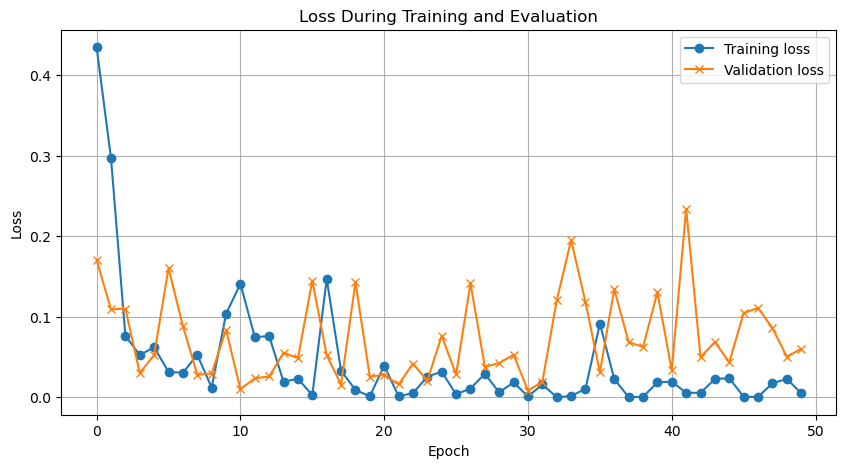

In [131]:
import matplotlib.pyplot as plt

# Assuming 'losses' is a list of float numbers representing the loss values
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(losses_train, label='Training loss', marker='o')
plt.plot(losses_valid, label='Validation loss', marker='x')  # Plot the losses with line and markers
plt.title('Loss During Training and Evaluation')  # Give the plot a title
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.grid(True)  # Enable grid for easier readability
plt.legend()
plt.show()  # Display the plot

In [61]:
def segment_features(features, segment_frames=44, hop_frames=1):
    # Number of feature frames in the file
    num_frames = features.shape[1]
    
    # Calculate the number of segments we can extract
    num_segments = 1 + (num_frames - segment_frames) // hop_frames
    
    # Prepare an array to store segments
    segments = []
    
    # Extract segments using a sliding window
    for i in range(num_segments):
        start_frame = i * hop_frames
        end_frame = start_frame + segment_frames
        segment = features[:, start_frame:end_frame]
        segments.append(segment)
        
    return np.array(segments)

In [60]:
frame_rate = 39
commands = []
labels = []
max_length = 0
min_end = 10000000
def extract_commands(frame_rate, start, max_length, snippet):
    start_frame = int(start * frame_rate)
    if snippet.shape[1] < start_frame + max_length:
        padding = np.zeros((snippet.shape[0], start_frame + max_length - snippet.shape[1]))
        snippet = np.hstack((snippet, padding))
    return snippet[:, start_frame:start_frame + max_length]

for i in range(len(data)):
    start = data_csv['start'][i] * frame_rate
    end = data_csv['end'][i] * frame_rate
    max_length = max(end - start, max_length)
    min_end = min(end, min_end)
max_length = int(max_length) + 1

    
for i in range(len(data)):
    start = data_csv['start'][i]
    snippet = data[i]
    commands.append(extract_commands(frame_rate, start, max_length, snippet))
    labels.append(data_csv['command'][i])

KeyError: 'start'

In [30]:
command_segments = []
for i in range(len(commands)):
    command_segments.append(segment_features(commands[i]))

In [31]:
for i in range(len(command_segments)):
    if command_segments[i+1].shape != command_segments[i].shape:
        print(command_segments[i].shape)

IndexError: list index out of range

In [32]:
commands_train = np.array(command_segments[:952])
commands_val = np.array(command_segments[952:])

labels_train = labels[:952]
labels_val = labels[952:]

In [33]:
i = 20
y = {}
labels_train_num = []
labels_val_num = []

for label in np.unique(labels).tolist():
    y[label] = i
    i += 1
    
for label in labels_train:
    labels_train_num.append(y[label])
for label in labels_val:
    labels_val_num.append(y[label])

labels_train_num = np.array(labels_train_num)
labels_val_num = np.array(labels_val_num)

In [35]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [37]:
from model_architectures import EnhancedAudioCNN

In [50]:
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

pretrained_model = EnhancedAudioCNN(num_classes=20)
checkpoint = torch.load ("model_epoch_17.pth", map_location=device)
pretrained_model.load_state_dict(checkpoint['model_state_dict'])

model = EnhancedAudioCNN(num_classes=37)

model_dict = model.state_dict()
pretrained_dict = pretrained_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "fc2" not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# Initialize the weights of the new output layer
nn.init.xavier_uniform_(model.fc2.weight)
nn.init.zeros_(model.fc2.bias)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

X_tensor_train = torch.tensor(commands_train, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor([labels_train_num], dtype=torch.long).to(device)
X_tensor_valid = torch.tensor(commands_val, dtype=torch.float32).to(device)
y_tensor_valid = torch.tensor([labels_val_num], dtype=torch.long).to(device)

model.to(device)

EnhancedAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=37, bias=True)
)

In [57]:
# Example training loop
num_epochs = 20
#total_iterations = num_epochs * (len(dataloader_train) + len(dataloader_valid))
#progress_bar = tqdm(total=total_iterations, desc='Training and Evaluation')

losses_train = []
losses_valid = []

for epoch in range(num_epochs):
    model.train()
    for features, labels in zip(X_tensor_train, y_tensor_train):
        optimizer.zero_grad()
        print(features[0].shape)
        inputs = features.unsqueeze(1).to(device)
        targets = labels.unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    losses_train.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for features, labels in zip(X_tensor_valid, y_tensor_valid):
            inputs = features.unsqueeze(1).to(device)
            targets = labels.unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        losses_valid.append(loss.item())
    if losses_train[-1] < 0.3 and losses_valid[-1] < 0.3:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_epoch_{epoch}.pth')
    #progress_bar.update(2)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training loss: {losses_train[-1]}, Validation loss: {losses_valid[-1]}')

torch.Size([175, 44])


ValueError: Expected input batch_size (66) to match target batch_size (952).